In [ ]:
import random
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [ ]:
class Card:
    __slots__ = ('rank', 'suit')
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit

class BlackjackEnvironment:
    def __init__(self, num_decks=6, penetration=0.70):
        self.num_decks = num_decks
        self.penetration = penetration
        self.cutoff = None

        self.value_map = {str(i): i for i in range(2, 11)}
        for face in ['jack', 'queen', 'king']: self.value_map[face] = 10
        self.value_map['ace'] = 11

        self.deck = []
        self.player_cards = []
        self.dealer_cards = []
        self.has_doubled_down = False
        self.game_over = False
        self.rewards = []
        self.visible_cards = []
        self.undo_available = False
        self.undo_used = False
        self.pre_hit_state = None
        self.reset_game()

    def _create_new_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        ranks = [str(i) for i in range(2, 11)] + ['jack', 'queen', 'king', 'ace']
        return [Card(rank, suit) for rank in ranks for suit in suits] * self.num_decks

    def _draw_random_card(self):
        if len(self.deck) < 20:
            self.deck = self._create_new_deck()
            random.shuffle(self.deck)
            self.cutoff = int(len(self.deck) * self.penetration)
        card = self.deck.pop()
        self.visible_cards.append(card)
        return card

    def reset_game(self):
        if not self.deck or len(self.deck) < (52 * self.num_decks * (1 - self.penetration)):
            self.deck = self._create_new_deck()
            random.shuffle(self.deck)
            self.cutoff = int(len(self.deck) * self.penetration)
        self.player_cards = [self._draw_random_card(), self._draw_random_card()]
        self.dealer_cards = [self._draw_random_card(), self._draw_random_card()]
        self.has_doubled_down = False
        self.game_over = False
        self.rewards = []
        self.visible_cards = self.player_cards.copy() + [self.dealer_cards[0]]
        self.undo_available = False
        self.undo_used = False
        self.pre_hit_state = None
        return self.get_current_state()

    def _get_card_value(self, card):
        return self.value_map[card.rank]

    def _calculate_hand_value(self, hand):
        total, ace_count = 0, 0
        for card in hand:
            if card.rank == 'ace':
                ace_count += 1
                total += 11
            else:
                total += self._get_card_value(card)
        while total > 21 and ace_count > 0:
            total -= 10
            ace_count -= 1
        return total

    def _has_soft_hand(self, hand):
        return any(c.rank == 'ace' for c in hand) and self._calculate_hand_value(hand) <= 21

    def _check_if_busted(self, hand):
        return self._calculate_hand_value(hand) > 21

    def _check_natural_blackjack(self, hand):
        return len(hand) == 2 and self._calculate_hand_value(hand) == 21

    def _play_dealer_hand(self):
        while self._calculate_hand_value(self.dealer_cards) < 17:
            self.dealer_cards.append(self._draw_random_card())

    def _finalize_round(self):
        player_value = self._calculate_hand_value(self.player_cards)
        dealer_value = self._calculate_hand_value(self.dealer_cards)
        if self._check_if_busted(self.dealer_cards):
            reward = 2 if self.has_doubled_down else 1
        elif player_value > dealer_value:
            reward = 2 if self.has_doubled_down else 1
        elif player_value < dealer_value:
            reward = -2 if self.has_doubled_down else -1
        else:
            reward = 0
        self.rewards.append(reward)
        return 'terminal', reward, True

    def get_current_state(self):
        if self.game_over:
            return 'terminal'
        return (self._calculate_hand_value(self.player_cards), self._get_card_value(self.dealer_cards[0]), self._has_soft_hand(self.player_cards), self.has_doubled_down, self.undo_available, self.undo_used)

    def step(self, action):
        if self.game_over:
            return 'terminal', 0, True

        if action not in ['h', 'u']:
            self.undo_available = False

        if action == 'u':
            if self.undo_available and not self.undo_used and self.pre_hit_state:
                self.player_cards = self.pre_hit_state['player_cards']
                self.deck = self.pre_hit_state['deck']
                self.visible_cards = self.pre_hit_state['visible_cards']
                self.has_doubled_down = self.pre_hit_state['has_doubled_down']
                self.undo_available = False
                self.undo_used = True
                return self.get_current_state(), 0, False
            else:
                return self.get_current_state(), -1, False

        if self._check_natural_blackjack(self.player_cards):
            reward = 1.5 if not self._check_natural_blackjack(self.dealer_cards) else 0
            self.rewards.append(reward)
            self.game_over = True
            return 'terminal', reward, True

        if action == 'h':
            if not self.undo_used:
                self.pre_hit_state = {'player_cards': self.player_cards.copy(), 'deck': self.deck.copy(), 'visible_cards': self.visible_cards.copy(), 'has_doubled_down': self.has_doubled_down}
                self.undo_available = True
            card = self._draw_random_card()
            self.player_cards.append(card)
            if self._check_if_busted(self.player_cards):
                reward = -2 if self.has_doubled_down else -1
                self.rewards.append(reward)
                self.game_over = True
                self.undo_available = False
                return 'terminal', reward, True
            return self.get_current_state(), 0, False

        elif action == 's':
            self._play_dealer_hand()
            return self._finalize_round()

        elif action == 'd':
            if not self.has_doubled_down and len(self.player_cards) == 2:
                self.has_doubled_down = True
                card = self._draw_random_card()
                self.player_cards.append(card)
                if self._check_if_busted(self.player_cards):
                    reward = -2
                    self.rewards.append(reward)
                    self.game_over = True
                    return 'terminal', reward, True
                self._play_dealer_hand()
                return self._finalize_round()
            else: # Invalid double down treated as a stand
                self._play_dealer_hand()
                return self._finalize_round()

        raise ValueError(f"Invalid action passed to step function: {action}")

    def get_true_count(self):
        running_count = 0
        for card in self.visible_cards:
            if card.rank in ['2', '3', '4', '5', '6']:
                running_count += 1
            elif card.rank in ['10', 'jack', 'queen', 'king', 'ace']:
                running_count -= 1
        remaining_decks = len(self.deck) / 52
        return running_count / max(remaining_decks, 0.5)

#Card Counting Strategy

In [ ]:
BASIC_STRATEGY_TABLE = {
    # Player has 4-8
    (8, 5): 'd', (8, 6): 'd',
    # Player has 9
    (9, 2): 'h', (9, 3): 'd', (9, 4): 'd', (9, 5): 'd', (9, 6): 'd',
    # Player has 10
    (10, 10): 'h', (10, 11): 'h',
    # Player has 11
    (11, 11): 'h',
    # Player has 12
    (12, 2): 'h', (12, 3): 'h', (12, 4): 's', (12, 5): 's', (12, 6): 's',
    # Player has 13-16
    (13, 2): 's', (13, 3): 's', (13, 4): 's', (13, 5): 's', (13, 6): 's',
    (14, 2): 's', (14, 3): 's', (14, 4): 's', (14, 5): 's', (14, 6): 's',
    (15, 2): 's', (15, 3): 's', (15, 4): 's', (15, 5): 's', (15, 6): 's',
    (16, 2): 's', (16, 3): 's', (16, 4): 's', (16, 5): 's', (16, 6): 's',
}

class CardCountingAgent:
    def choose_action(self, env):
        state = env.get_current_state()
        if state == 'terminal':
            return None

        player_total, dealer_up, is_soft, _, undo_available, _ = state

        # --- UNDO LOGIC ---
        # If undo is available and we just made our hand worse in a favorable count, undo it.
        true_count = env.get_true_count()
        if undo_available and true_count > 1 and 12 <= player_total <= 16:
            return 'u' # Undo the bad hit

        # --- BASIC STRATEGY LOGIC ---
        # Double down on 10 or 11 if not against a 10 or Ace
        if player_total in [10, 11] and len(env.player_cards) == 2:
            if player_total == 11 and dealer_up < 11: return 'd'
            if player_total == 10 and dealer_up < 10: return 'd'

        # Soft hands strategy (simplified)
        if is_soft:
            if player_total >= 19: return 's'
            if player_total == 18 and dealer_up > 8: return 'h'
            return 's'

        # Hard totals strategy
        if player_total >= 17: return 's'
        if player_total <= 8: return 'h'

        # Look up in the table for totals 9-16
        action = BASIC_STRATEGY_TABLE.get((player_total, dealer_up), 'h')

        # Ensure we don't try to double down after the first two cards
        if action == 'd' and len(env.player_cards) > 2:
            action = 'h'

        return action

#Q-Learning Agent

In [ ]:
class Q_learning:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.95, epsilon=1.0):
        self.actions = actions
        self.alpha = learning_rate      # Learning rate (α)
        self.gamma = discount_factor    # Discount factor (γ)
        self.epsilon = epsilon          # Exploration rate (ε)
        # Initialize Q-table with default values of 0
        self.q_table = collections.defaultdict(lambda: collections.defaultdict(float))

    def _get_binned_state(self, env, state):
        """Creates a discretized state representation for the Q-table."""
        if state == 'terminal':
            return 'terminal'

        player_total, dealer_up, is_soft, has_doubled, undo_available, undo_used = state
        true_count = env.get_true_count()

        # Bin the true count to keep the state space manageable
        if true_count < -2:
            tc_bin = -2
        elif true_count < 2:
            tc_bin = 0
        else:
            tc_bin = 2

        # The state includes player hand, dealer card, and the binned true count
        return (player_total, dealer_up, is_soft, tc_bin, undo_available)

    def choose_action(self, state_bin):
        """
        Chooses an action using an epsilon-greedy policy.
        - With probability epsilon, chooses a random action (exploration).
        - With probability 1-epsilon, chooses the best known action (exploitation).
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            # Choose the action with the highest Q-value for the current state
            q_values = self.q_table[state_bin]
            return max(q_values, key=q_values.get) if q_values else np.random.choice(self.actions)

    def update(self, state_bin, action, reward, next_state_bin):
        """
        Updates the Q-table using the Bellman equation (Q-learning update rule).
        Q(s, a) <- Q(s, a) + α * [r + γ * max_a'(Q(s', a')) - Q(s, a)]
        """
        # Find the best Q-value for the next state
        max_next_q = max(self.q_table[next_state_bin].values()) if self.q_table[next_state_bin] else 0

        # Calculate the TD target
        td_target = reward + self.gamma * max_next_q

        # Update the Q-value for the current state-action pair
        current_q = self.q_table[state_bin][action]
        self.q_table[state_bin][action] += self.alpha * (td_target - current_q)

Starting training for 2000000 episodes...
Training finished.

Running evaluation for 500000 episodes...

--- Final Policy Evaluation Metrics ---
(Based on the last 500000 episodes with ε≈0.05)
  Win Rate: 41.37%
  Loss Rate: 49.15%
  Push Rate: 9.47%
  Player Advantage / Return per Hand: -6.8711%

Rule Variation Usage:
  'Undo' was used 138,497 times.



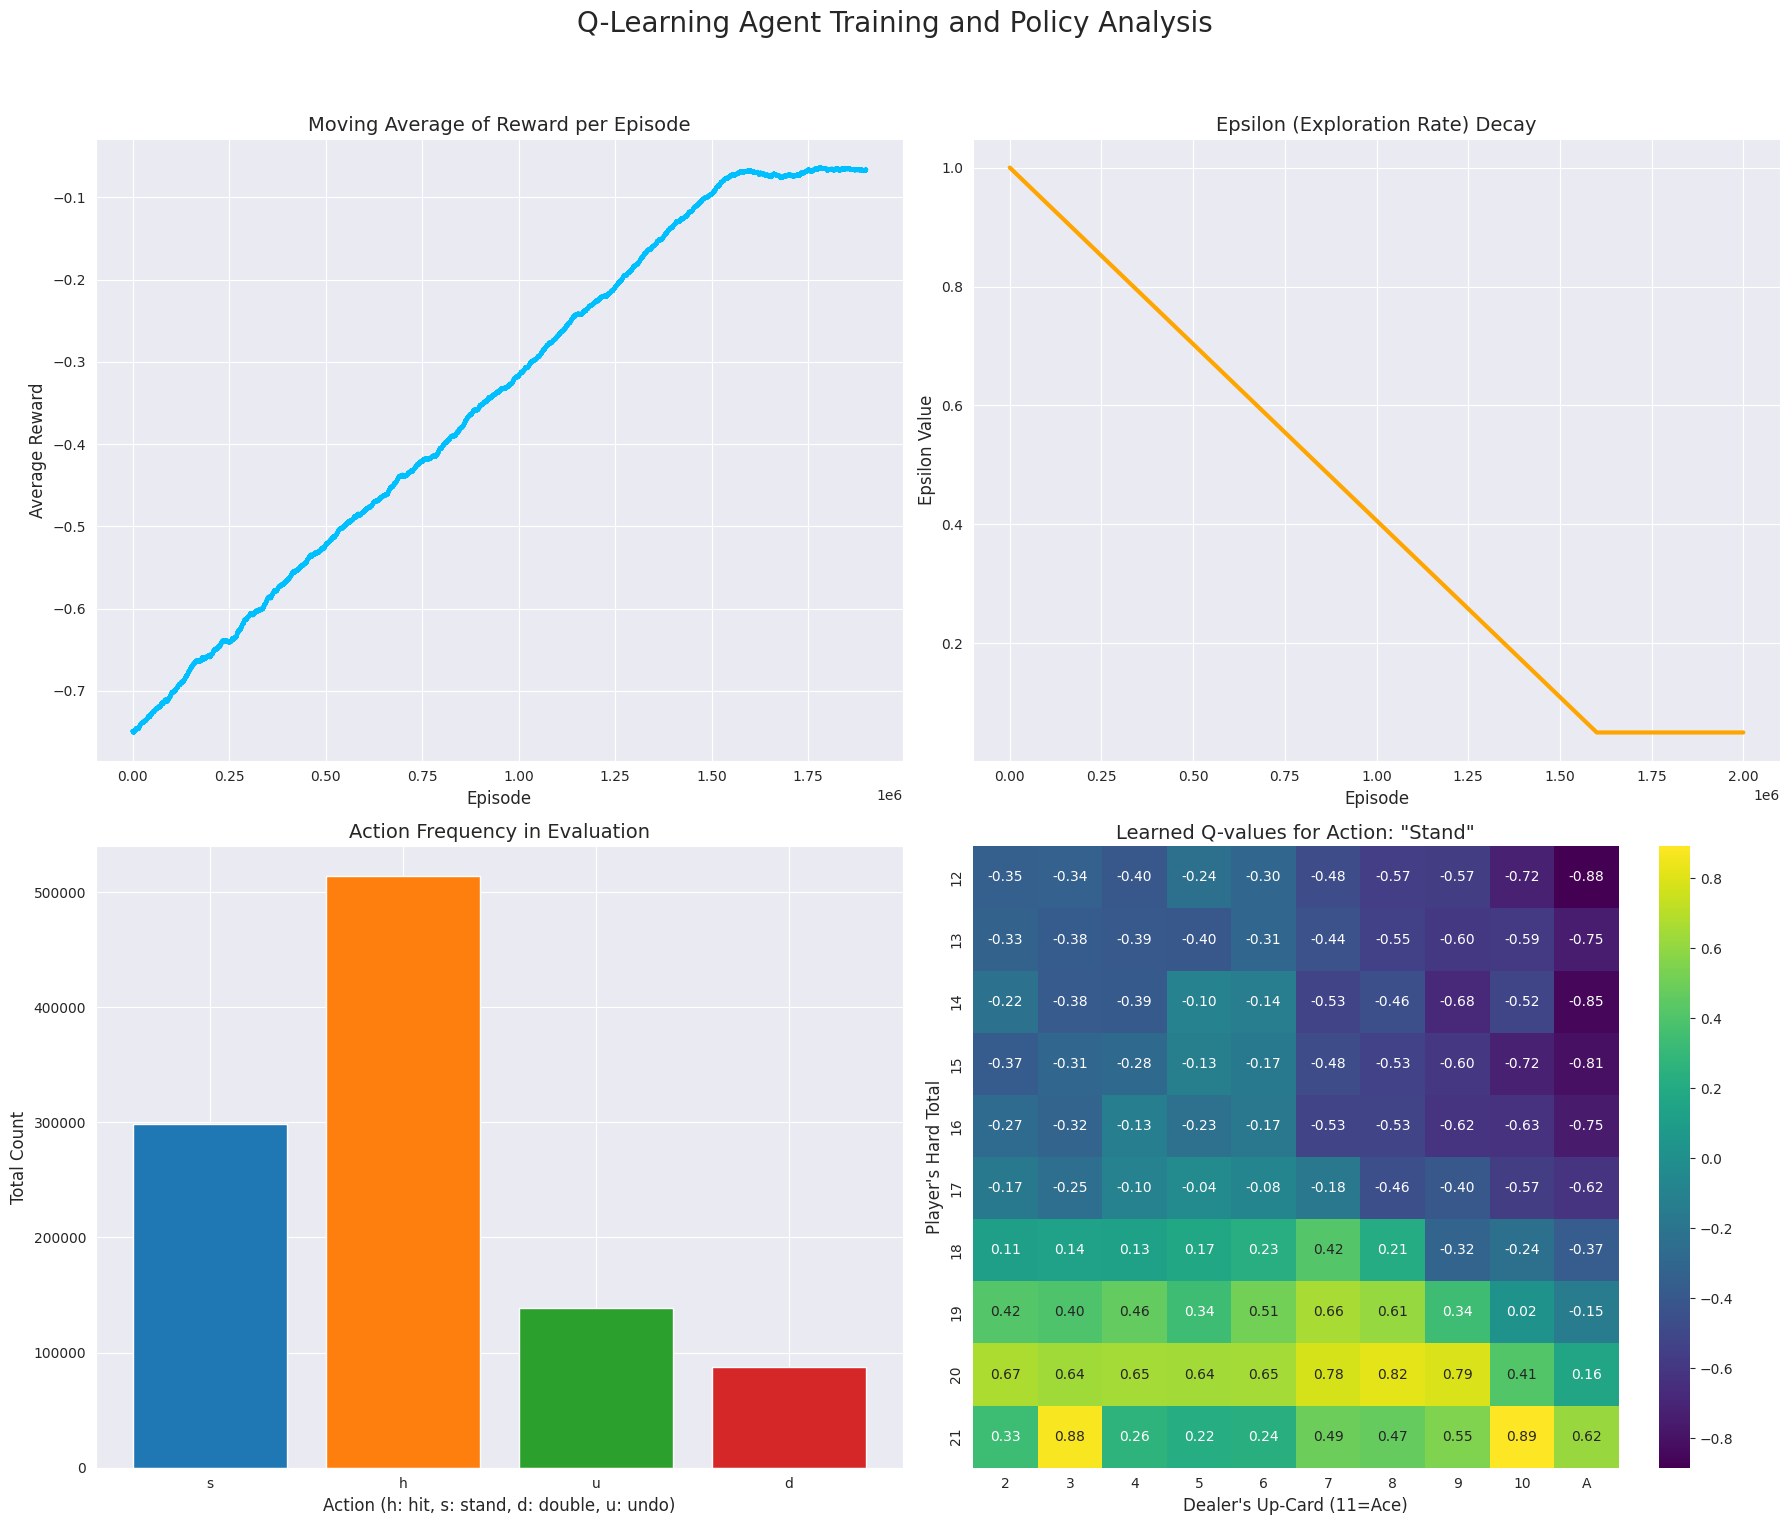

In [ ]:
def train_and_evaluate_agent(n_episodes=2000000, eval_episodes=500000):
    # --- 1. Initialization and Training ---
    env = BlackjackEnvironment()
    agent = Q_learning(actions=['h', 's', 'd', 'u'], learning_rate=0.01, discount_factor=0.95, epsilon=1.0)

    rewards_log = []
    epsilon_log = []

    min_epsilon = 0.05
    epsilon_decay = (agent.epsilon - min_epsilon) / (n_episodes * 0.8)

    print(f"Starting training for {n_episodes} episodes...")
    for i in range(n_episodes):
        state = env.reset_game()
        state_bin = agent._get_binned_state(env, state)
        done = False
        episode_reward = 0

        while not done:
            action = agent.choose_action(state_bin)
            next_state, reward, done = env.step(action)
            next_state_bin = agent._get_binned_state(env, next_state)
            agent.update(state_bin, action, reward, next_state_bin)
            episode_reward += reward
            state_bin = next_state_bin

        rewards_log.append(episode_reward)
        epsilon_log.append(agent.epsilon)
        agent.epsilon = max(min_epsilon, agent.epsilon - epsilon_decay)
    print("Training finished.")

    # --- 2. Evaluation Phase ---
    print(f"\nRunning evaluation for {eval_episodes} episodes...")
    action_counts = collections.Counter()
    eval_rewards = []
    for _ in range(eval_episodes):
        state = env.reset_game()
        state_bin = agent._get_binned_state(env, state)
        done = False
        episode_reward = 0
        while not done:
            action = agent.choose_action(state_bin)
            action_counts[action] += 1
            next_state, reward, done = env.step(action)
            episode_reward += reward
            state_bin = agent._get_binned_state(env, next_state)
        eval_rewards.append(episode_reward)

    # --- 3. Final Metrics Calculation & Report ---
    wins = sum(1 for r in eval_rewards if r > 0)
    losses = sum(1 for r in eval_rewards if r < 0)
    pushes = eval_episodes - wins - losses

    print("\n" + "="*40)
    print("--- Final Policy Evaluation Metrics ---")
    print(f"(Based on the last {eval_episodes} episodes with ε≈{agent.epsilon:.2f})")
    print("="*40)
    print(f"  Win Rate: {wins / eval_episodes * 100:.2f}%")
    print(f"  Loss Rate: {losses / eval_episodes * 100:.2f}%")
    print(f"  Push Rate: {pushes / eval_episodes * 100:.2f}%")
    print(f"  Player Advantage / Return per Hand: {np.mean(eval_rewards) * 100:.4f}%")
    print("\nRule Variation Usage:")
    print(f"  'Undo' was used {action_counts.get('u', 0):,} times.")
    print("="*40 + "\n")

    # --- 4. Data Preparation for Plots ---
    player_totals = range(12, 22)
    dealer_cards = range(2, 12)
    q_matrix = np.zeros((len(player_totals), len(dealer_cards)))

    for i, p_total in enumerate(player_totals):
        for j, d_card in enumerate(dealer_cards):
            state = (p_total, d_card, False, 0, False)
            q_matrix[i, j] = agent.q_table[state]['s']

    # --- 5. Plotting ---
    sns.set_style("darkgrid")
    fig, axs = plt.subplots(2, 2, figsize=(18, 16))
    fig.suptitle('Q-Learning Agent Training and Policy Analysis', fontsize=20)

    # Plot 1: Moving Average of Reward
    window = int(n_episodes * 0.05)
    moving_avg_rewards = np.convolve(rewards_log, np.ones(window), 'valid') / window
    axs[0, 0].plot(moving_avg_rewards, color='deepskyblue', linewidth=3)
    axs[0, 0].set_title('Moving Average of Reward per Episode', fontsize=14)
    axs[0, 0].set_xlabel('Episode', fontsize=12)
    axs[0, 0].set_ylabel('Average Reward', fontsize=12)

    # Plot 2: Epsilon Decay
    axs[0, 1].plot(epsilon_log, color='orange', linewidth=3)
    axs[0, 1].set_title('Epsilon (Exploration Rate) Decay', fontsize=14)
    axs[0, 1].set_xlabel('Episode', fontsize=12)
    axs[0, 1].set_ylabel('Epsilon Value', fontsize=12)

    # Plot 3: Action Frequency
    actions = list(action_counts.keys())
    counts = list(action_counts.values())
    bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    axs[1, 0].bar(actions, counts, color=bar_colors)
    axs[1, 0].set_title('Action Frequency in Evaluation', fontsize=14)
    axs[1, 0].set_xlabel("Action (h: hit, s: stand, d: double, u: undo)", fontsize=12)
    axs[1, 0].set_ylabel('Total Count', fontsize=12)

    # Plot 4: Heatmap of Q-values for "Stand"
    heatmap = sns.heatmap(
        q_matrix, ax=axs[1, 1], annot=True, fmt=".2f", cmap='viridis',
        xticklabels=[str(d) for d in dealer_cards[:-1]] + ['A'], yticklabels=player_totals
    )
    heatmap.set_title('Learned Q-values for Action: "Stand"', fontsize=14)
    heatmap.set_xlabel("Dealer's Up-Card (11=Ace)", fontsize=12)
    heatmap.set_ylabel("Player's Hard Total", fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Run the entire process ---
train_and_evaluate_agent()

#SARSA Agent

In [ ]:
class SarsaAgent:
    def __init__(self, learning_rate=0.001, discount_factor=0.85, epsilon=1.0, epsilon_decay=0.999999, epsilon_min=0.09):
        # Hyperparameters
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Q-table
        self.q_table = defaultdict(lambda: defaultdict(float))

    def _discretize_state(self, env):
        """Converts the environment's state into a hashable tuple for the Q-table."""
        raw_state = env.get_current_state()
        if raw_state == 'terminal':
            return 'terminal'

        player_total, dealer_up, is_soft, _, undo_available, undo_used = raw_state

        # Discretize true count into buckets
        true_count = env.get_true_count()
        if true_count < -1: count_bucket = -2
        elif true_count < 1: count_bucket = 0
        elif true_count < 3: count_bucket = 2
        else: count_bucket = 4

        return (player_total, dealer_up, is_soft, count_bucket, undo_available, undo_used)

    def _get_valid_actions(self, env):
        """Returns a list of actions that are valid in the current game state."""
        actions = ['h', 's']
        raw_state = env.get_current_state()

        if len(env.player_cards) == 2: actions.append('d')
        if raw_state[4]: actions.append('u') # If undo_available is True

        return actions

    def choose_action(self, env):
        """Chooses an action using an epsilon-greedy policy."""
        state = self._discretize_state(env)
        valid_actions = self._get_valid_actions(env)

        if np.random.rand() < self.epsilon:
            return np.random.choice(valid_actions)
        else:
            q_values = self.q_table[state]
            valid_q_values = {action: q_values[action] for action in valid_actions}
            return max(valid_q_values, key=valid_q_values.get)

    def update_q_table(self, state, action, reward, next_state, next_action):
        """Updates the Q-value using the SARSA update rule."""
        current_q = self.q_table[state][action]

        # Get the Q-value for the next state and the action that was actually chosen
        next_q = self.q_table[next_state][next_action]

        # SARSA formula: S, A, R, S', A'
        new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        self.q_table[state][action] = new_q

    def decay_epsilon(self):
        """Reduces epsilon to shift from exploration to exploitation."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

--- Starting SARSA Training ---
Episode 20000/2000000 | Epsilon: 0.980
Episode 40000/2000000 | Epsilon: 0.961
Episode 60000/2000000 | Epsilon: 0.942
Episode 80000/2000000 | Epsilon: 0.923
Episode 100000/2000000 | Epsilon: 0.905
Episode 120000/2000000 | Epsilon: 0.887
Episode 140000/2000000 | Epsilon: 0.869
Episode 160000/2000000 | Epsilon: 0.852
Episode 180000/2000000 | Epsilon: 0.835
Episode 200000/2000000 | Epsilon: 0.819
Episode 220000/2000000 | Epsilon: 0.803
Episode 240000/2000000 | Epsilon: 0.787
Episode 260000/2000000 | Epsilon: 0.771
Episode 280000/2000000 | Epsilon: 0.756
Episode 300000/2000000 | Epsilon: 0.741
Episode 320000/2000000 | Epsilon: 0.726
Episode 340000/2000000 | Epsilon: 0.712
Episode 360000/2000000 | Epsilon: 0.698
Episode 380000/2000000 | Epsilon: 0.684
Episode 400000/2000000 | Epsilon: 0.670
Episode 420000/2000000 | Epsilon: 0.657
Episode 440000/2000000 | Epsilon: 0.644
Episode 460000/2000000 | Epsilon: 0.631
Episode 480000/2000000 | Epsilon: 0.619
Episode 5000

/tmp/ipython-input-12-1630435223.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_labels, y=counts, ax=axes[1, 0], palette='viridis')


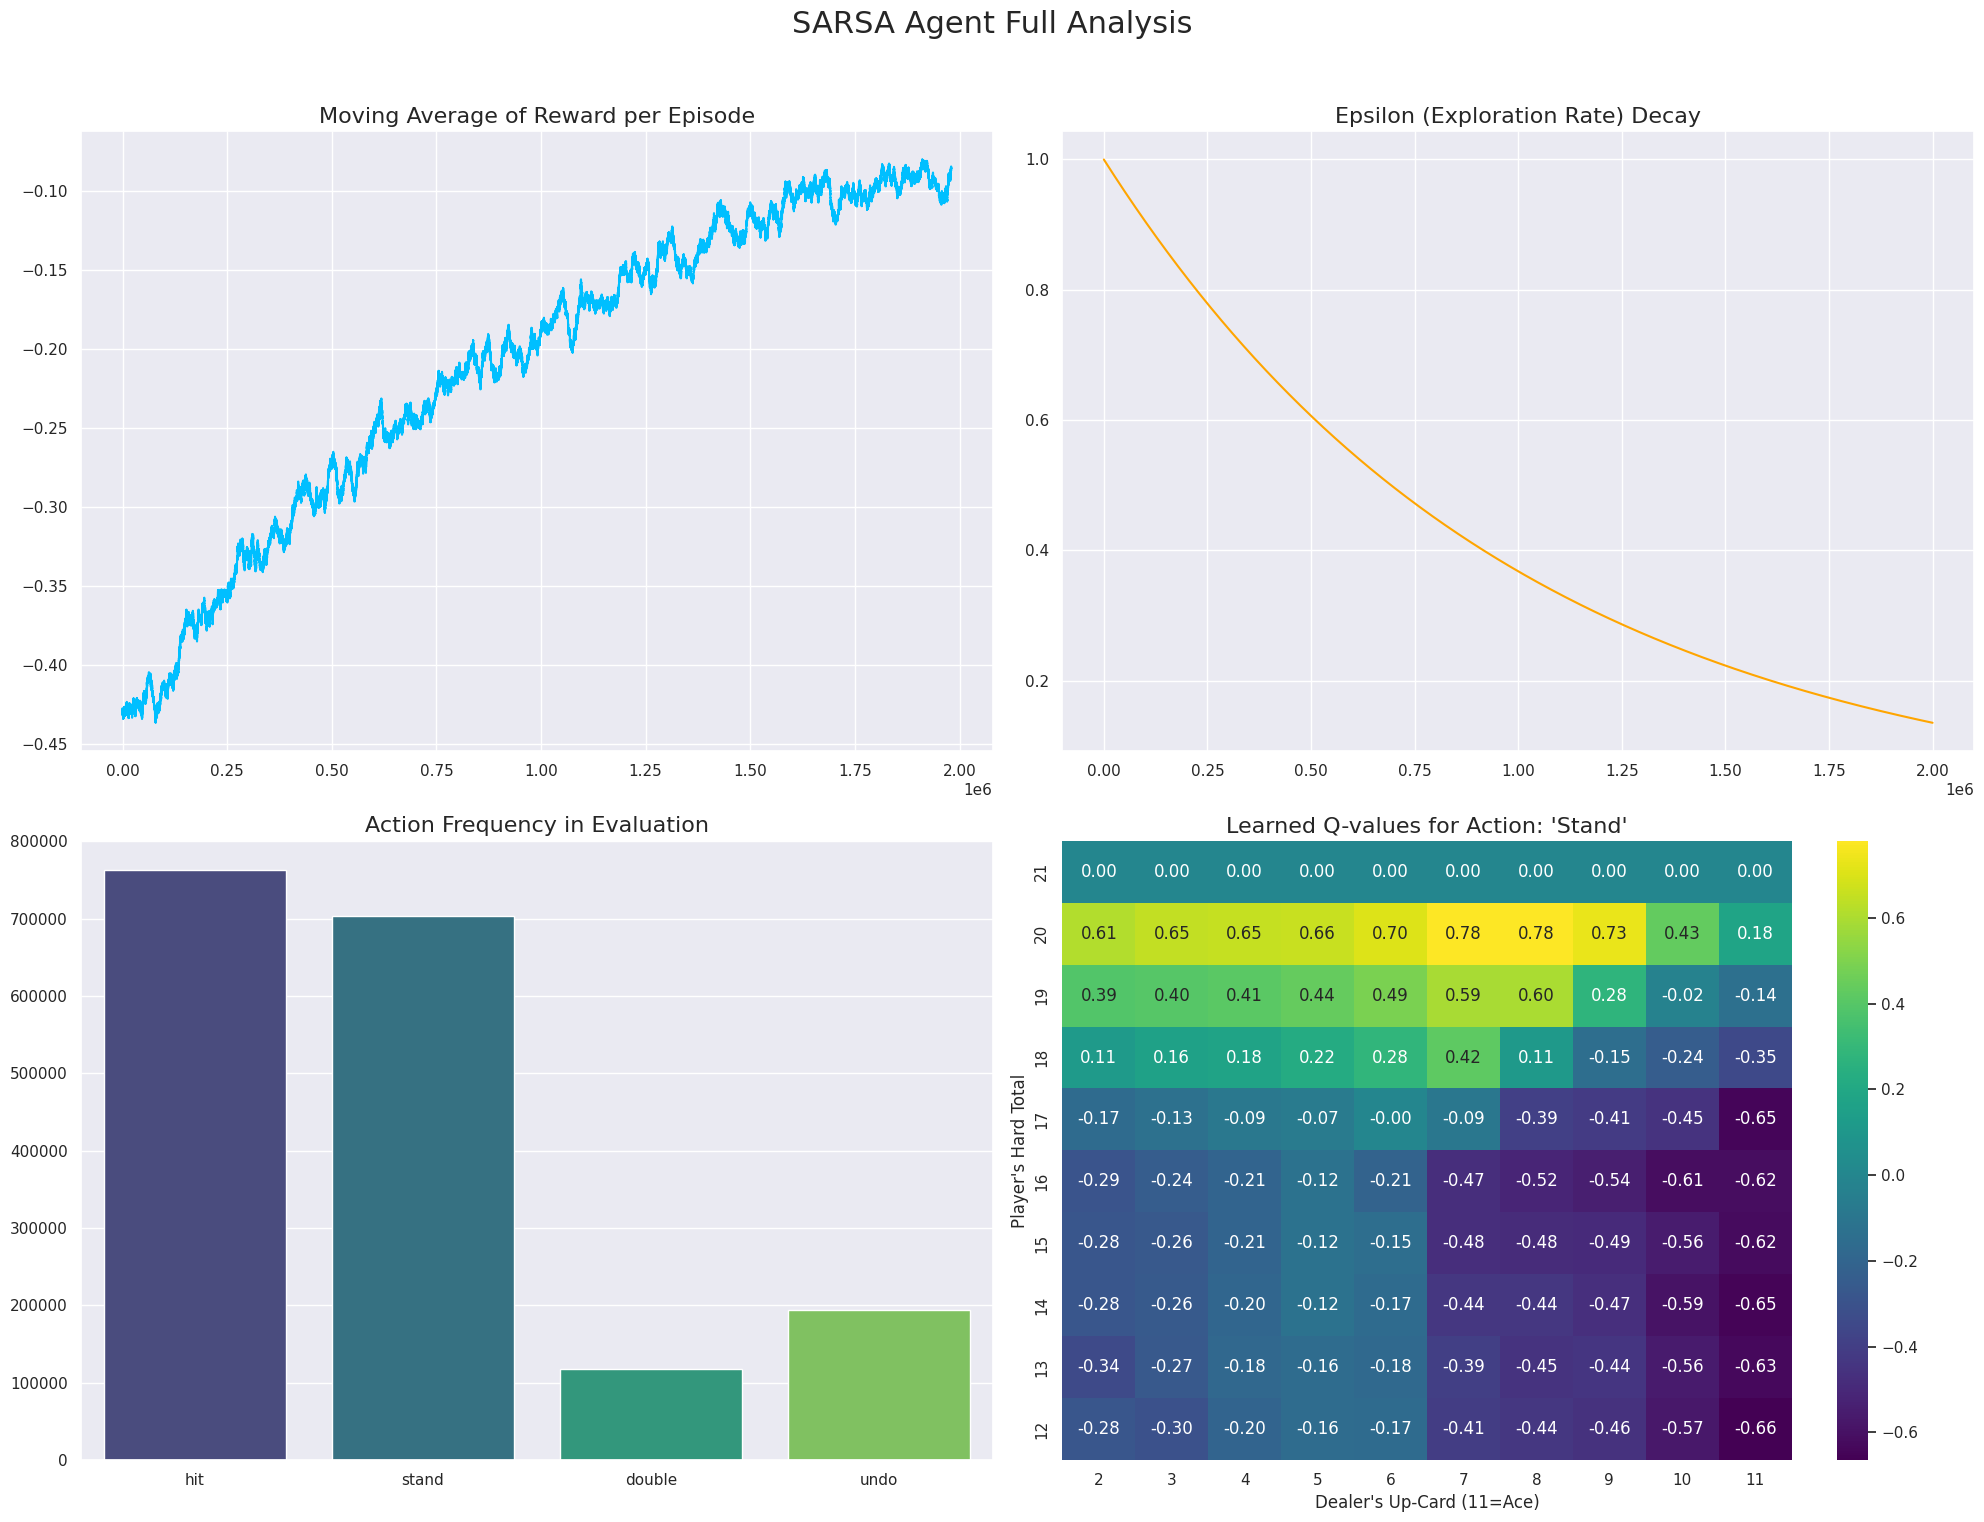

In [ ]:
def train_sarsa_agent(env, agent, num_episodes=2000000):
    """Trains the SARSA agent and returns its reward and epsilon histories."""
    reward_history = []
    epsilon_history = []  # List to store epsilon values

    for episode in range(num_episodes):
        epsilon_history.append(agent.epsilon)  # Track epsilon

        env.reset_game()
        state = agent._discretize_state(env)
        action = agent.choose_action(env)
        done = False

        while not done:
            _, reward, done = env.step(action)
            next_state = agent._discretize_state(env)
            next_action = agent.choose_action(env) if not done else None
            agent.update_q_table(state, action, reward, next_state, next_action)
            state = next_state
            action = next_action

        reward_history.append(reward)
        agent.decay_epsilon()

        if (episode + 1) % 20000 == 0:
            print(f"Episode {episode + 1}/{num_episodes} | Epsilon: {agent.epsilon:.3f}")

    return reward_history, epsilon_history

def evaluate_agent(env, agent, num_episodes, reward_history, epsilon_history):
    """
    Evaluates the agent, prints detailed metrics, and plots a full analysis.
    """
    agent.epsilon = 0
    total_rewards = []
    wins, losses, pushes = 0, 0, 0
    action_counts = defaultdict(int)

    # --- 1. Run Evaluation Games ---
    for _ in range(num_episodes):
        env.reset_game()
        done = False
        reward = 0
        while not done:
            action = agent.choose_action(env)
            action_counts[action] += 1
            _, reward, done = env.step(action)

        total_rewards.append(reward)
        if reward > 0: wins += 1
        elif reward < 0: losses += 1
        else: pushes += 1

    # --- 2. Print Detailed Metrics ---
    print(f"\n--- Evaluation Metrics ({num_episodes:,} Hands) ---")
    print(f"Win Rate: {wins/num_episodes:.2%}")
    print(f"Loss Rate: {losses/num_episodes:.2%}")
    print(f"Push Rate: {pushes/num_episodes:.2%}")
    print(f"Player Advantage / Return per Hand: {np.mean(total_rewards):.4f}")
    print("\nRule Variation Usage:")
    print(f"  'Undo' Actions Used: {action_counts.get('u', 0):,}")
    print("-------------------------------------------------")

    # --- 3. Generate Full 2x2 Analysis Plot ---
    print("\n--- Generating Full Analysis Plot ---")
    sns.set_theme(style="darkgrid")
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('SARSA Agent Full Analysis', fontsize=22)

    # Plot 2.1: Rewards vs. Episodes
    window = int(len(reward_history) * 0.01)
    moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
    axes[0, 0].plot(moving_avg, color='deepskyblue')
    axes[0, 0].set_title('Moving Average of Reward per Episode', fontsize=16)

    # Plot 2.2: Epsilon Decay
    axes[0, 1].plot(epsilon_history, color='orange')
    axes[0, 1].set_title('Epsilon (Exploration Rate) Decay', fontsize=16)

    # Plot 2.3: Action Frequency
    action_labels = ["hit", "stand", "double", "undo"]
    counts = [action_counts.get(key, 0) for key in ['h', 's', 'd', 'u']]
    sns.barplot(x=action_labels, y=counts, ax=axes[1, 0], palette='viridis')
    axes[1, 0].set_title('Action Frequency in Evaluation', fontsize=16)

    # Plot 2.4: Q-value Heatmap for 'Stand'
    player_totals, dealer_cards = range(21, 11, -1), range(2, 12)
    heatmap_data = np.zeros((len(player_totals), len(dealer_cards)))
    for i, p_total in enumerate(player_totals):
        for j, d_card in enumerate(dealer_cards):
            state_key = (p_total, d_card, False, 0, False, False)
            heatmap_data[i, j] = agent.q_table.get(state_key, {}).get('s', 0)
    sns.heatmap(heatmap_data, ax=axes[1, 1], annot=True, fmt=".2f", cmap='viridis', xticklabels=dealer_cards, yticklabels=player_totals)
    axes[1, 1].set_title("Learned Q-values for Action: 'Stand'", fontsize=16)
    axes[1, 1].set_xlabel("Dealer's Up-Card (11=Ace)")
    axes[1, 1].set_ylabel("Player's Hard Total")

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

# --- Main Execution ---
if __name__ == '__main__':
    # Assume SarsaAgent and BlackjackEnvironment are defined
    blackjack_env = BlackjackEnvironment(num_decks=6)
    sarsa_agent = SarsaAgent()

    # 1. Train the agent and capture both histories
    print("--- Starting SARSA Training ---")
    rewards, epsilons = train_sarsa_agent(blackjack_env, sarsa_agent, num_episodes=2000000)

    # 2. Evaluate the agent, print metrics, and generate all plots
    evaluate_agent(blackjack_env, sarsa_agent, num_episodes=1000000, reward_history=rewards, epsilon_history=epsilons)